# **Parking lot problem**

### Part a. Forecast total number of vehicles entering the parking per day, for next 7 days



# Processing and Visualizing Data

<Axes: >

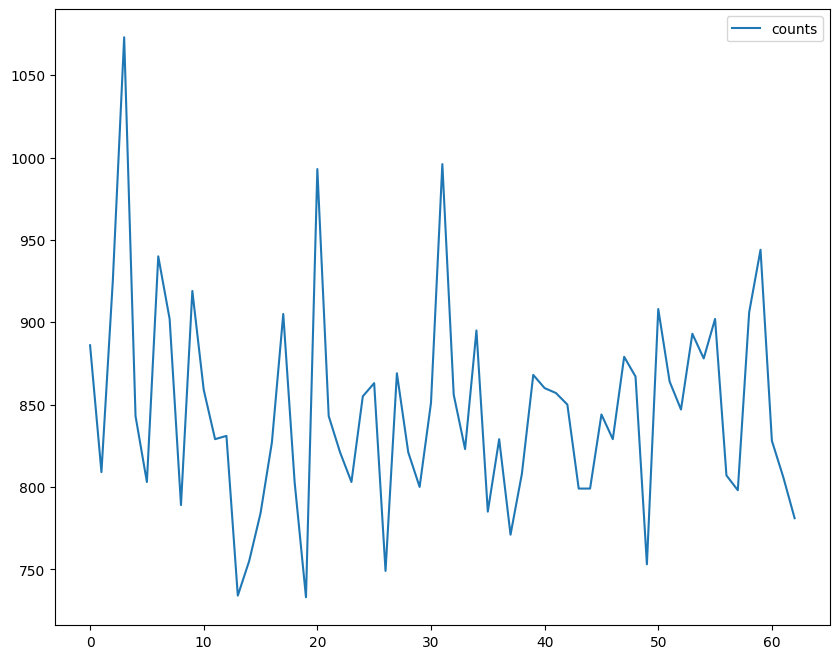

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#loading data
data = pd.read_csv("parkingLot (1).csv")

#removing year from timestamp (beacause all are 2024)
data["timestamp"] = data["timestamp"].str[5:10]

#spearating entry and exit data
index = data['camera_id'] == 1

data_entry = data[index]
data_entry = data_entry.groupby(["timestamp"]).size().reset_index(name='counts')

data_exit = data[~index]
data_exit = data_exit.groupby(["timestamp"]).size().reset_index(name='counts')

#plottting entry data
fig, ax = plt.subplots()

data_entry.plot(ax= ax, figsize=(10, 8))

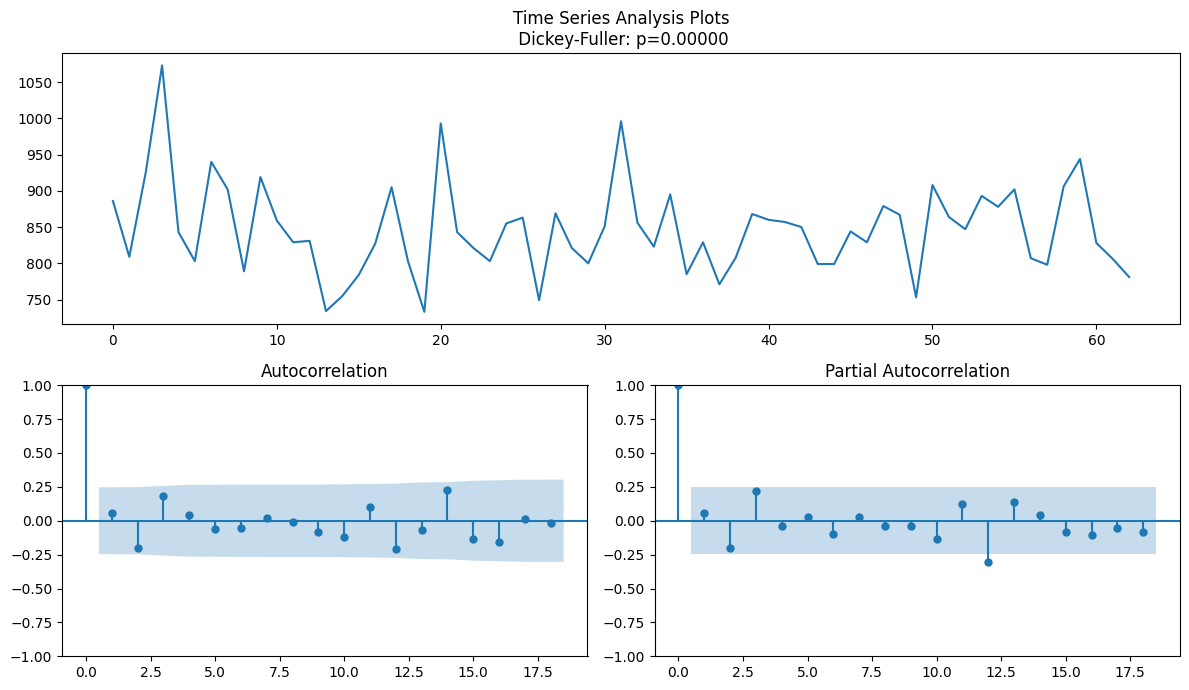

In [89]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(data_entry["counts"])

data is a stationary series hence no need for differencing 

# Test, Train Split

for (a) part of Q1 we only need to use data_entry

In [90]:
data_train = data_entry[:-7]
data_test = data_entry[-7:]

#  Fitting the ARIMA model

1. Manual Fitting
    - choosing p, d, q manually
2. Auto Fittting

### Ignoring warnings

In [105]:
import warnings
warnings.filterwarnings("ignore")

### Manual Fitting

In [136]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_train["counts"], order=(0,0,0), seasonal_order=(3, 0, 2, 7))
model_fit = model.fit()
#print(model_fit.summary())

### Auto Fitting

In [127]:
import pmdarima as pm
auto_arima = pm.auto_arima(data_train["counts"], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Forecasting and Error Calculation


<Axes: >

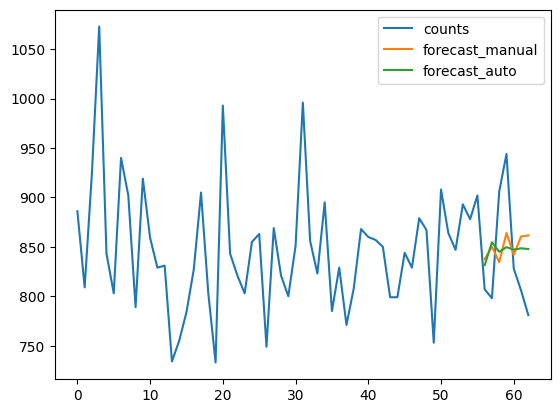

In [137]:
forecast_test = model_fit.forecast(len(data_test))
data_entry['forecast_manual'] = [None]*len(data_train) + list(forecast_test)

forecast_test_auto = auto_arima.predict(n_periods=len(data_test))
data_entry['forecast_auto'] = [None]*len(data_train) + list(forecast_test_auto)

data_entry.plot()

In [133]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(data_test["counts"], forecast_test)
mape = mean_absolute_percentage_error(data_test["counts"], forecast_test)
rmse = np.sqrt(mean_squared_error(data_test["counts"], forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 53.392874078690056
mape - manual: 0.0630955388624564
rmse - manual: 58.50900881432818


In [130]:
mae = mean_absolute_error(data_test["counts"], forecast_test_auto)
mape = mean_absolute_percentage_error(data_test["counts"], forecast_test_auto)
rmse = np.sqrt(mean_squared_error(data_test["counts"], forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 52.13852676672676
mape - auto: 0.06143480390380634
rmse - auto: 57.400046803441576
